In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from matplotlib.pyplot import imshow

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [3]:
from helper import plot_confusion_matrix, metrics

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import utils, configs
import argparse

def get_command_line_args(_args):
    parser = utils._build_parser()

    parser = parser.parse_args(_args)

    utils.check_args_validity(parser)

    print("=" * 20 + "\nParameters: \n")
    for key in parser.__dict__:
        print(key + ': ' + str(parser.__dict__[key]))
    print("=" * 20 + "\n")
    return parser

In [6]:
TEST_BATCH = 100

@tf.function
def preproc(x):
    img = tf.image.rgb_to_grayscale(x)
    img = tf.image.resize(img, size=[28,28])
    return img

with tf.device('CPU'):
    # load dataset from tfds (or use downloaded version if exists)
    fashion_test = get_train_test_data("fashion_mnist")[1]
    fashion_test = fashion_test.shuffle(10000).batch(TEST_BATCH)
    fashion_test = fashion_test.cache().take(1)

    mnist_test = get_train_test_data("mnist")[1]
    mnist_test = mnist_test.shuffle(10000).batch(TEST_BATCH)
    mnist_test = mnist_test.cache().take(1)
    
    cifar_test = get_train_test_data("cifar10")[1]
    cifar_test = cifar_test.map(preproc)
    cifar_test = cifar_test.shuffle(10000).batch(TEST_BATCH)
    cifar_test = cifar_test.cache().take(1)

In [7]:
with tf.device('CPU'):
    mnist_test = get_train_test_data("mnist")[1]
    mnist_test = mnist_test.batch(1000)

## TODO: Get samples from each label

In [8]:
mnist_batch = [x for x in mnist_test]

In [17]:
N_IMAGES = 10
mnist_seeds = mnist_batch[0][:N_IMAGES]

In [18]:
mnist_seeds.shape

TensorShape([10, 28, 28, 1])

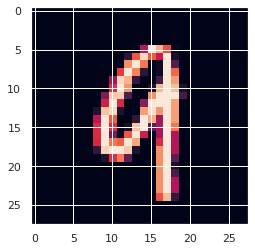

In [9]:
imshow(mnist_batch[0][42,...,0])

## FashionMNIST - Baseline --sigma_low=0.01

In [10]:
args = get_command_line_args(["--checkpoint_dir=longleaf_models/",
                              "--filters=64",
                              "--dataset=fashion_mnist",
                              "--sigma_low=0.01",
                              "--sigma_high=1"
                             ])
configs.config_values = args
SIGMAS = utils.get_sigma_levels().numpy()
SIGMAS

Parameters: 

experiment: train
dataset: fashion_mnist
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: longleaf_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2



array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

In [11]:
SPLITS = [1,0]

In [12]:
save_dir, complete_model_name = utils.get_savemodel_dir() 
model, optimizer, step, _, _ = utils.try_load_model(save_dir,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

(1, 28, 28, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   640         images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 28, 28, 64)   77696       conv2d[0][0]                     
                                                                 idx_sigmas[0][

## Sampling 

In [573]:
def save_as_timeline(images, filename=None, spacing=2, resize_ratio=4, fontsize=8,
                     row_labels=[], col_labels=[], captions=[]):
    """
    Partially from https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy
    :param images:
    :return:
    """

    # Define grid dimensions
    n_timepoints, n_images, height, width, channels = images.shape
    rows = n_images
    cols = n_timepoints
    
    # Process image
    # images = _preprocess_image_to_save(images)

    # Init image
    grid_rows = rows * height + (rows + 1) * spacing + fontsize
    grid_cols = cols * width + (cols + 1) * spacing  + fontsize * resize_ratio

#     mode = 'LA' if channels == 1 else "RGB"
    mode="RGB"
    im = Image.new(mode, (grid_cols, grid_rows))
    
    for col in range(n_timepoints):
        for row in range(n_images):
            x = col * width + (1 + col) * spacing  + fontsize * resize_ratio
            y = row * height + (1 + row) * spacing + fontsize
            im.paste(tf.keras.preprocessing.image.array_to_img(images[col,row]), (x, y))
            
    im = im.resize((grid_cols*resize_ratio, grid_rows*resize_ratio), resample=PIL.Image.LANCZOS)
    
    d = ImageDraw.Draw(im)
    fnt = ImageFont.truetype("LiberationSans-Bold.ttf", fontsize * resize_ratio)
#         fnt = ImageFont.truetype("arial.ttf", 52)
    fill = -255
    
    for col, label in enumerate(col_labels):
        x = (col * width+ (1 + col) * spacing) * resize_ratio  + fontsize * (resize_ratio**2)
        y = 0 #fontsize * resize_ratio
        d.text((x, y), label, font=fnt, fill=fill)
    
    for row, label in enumerate(row_labels):
        x = 0 
        y = (row * height + (1 + row) * spacing + fontsize*2) * resize_ratio
        d.text((x, y), label, font=fnt, fill=fill)
    
    ## Captions ##
    fnt = ImageFont.truetype("LiberationSans-Bold.ttf", (fontsize-2) * resize_ratio)
#     fnt = ImageFont.truetype("arial.ttf", 42)
    fill = 255
    
    for col, labels in enumerate(captions):
        for row, label in enumerate(labels):
            # Ignore caption -- keep blank
            if label == None or np.isnan(label):
                continue
            
            label = "{:.2f}".format(label)
            x = (col * width+ (1 + col) * spacing) * resize_ratio  + fontsize * (resize_ratio**2)
            y = ((row+0.99) * height + (1 + row) * spacing) * resize_ratio + fontsize//2
            d.text((x, y), label, font=fnt, fill="red")
    
    if filename:
        im.save(filename, format="PNG")
    return im

In [635]:
@tf.function(experimental_compile=True)
def climb_score(x,score, alpha_i):
    z_t = tf.random.normal(shape=x.get_shape(), mean=0, stddev=1.0)
    noise = tf.sqrt(alpha_i) * z_t
    x = x + alpha_i / 2 * score + noise
    return x


@tf.function
def original_step(model, x, idx_sigmas, alpha_i):
    score = model([x, idx_sigmas])
    return climb_score(x, score, alpha_i)

In [654]:
@tf.function(experimental_compile=True)
def climb_score_new(x,score, alpha_i):
    z_t = tf.random.normal(shape=x.get_shape(), mean=0, stddev=1.0)

    eps = 2e-4
#     noise = eps * z_t
    noise = tf.sqrt(eps) * z_t
    
    x = x + eps * score + noise
    return x

@tf.function
def modded_step(model, x, idx_sigmas, alpha_i):
    score = model([x, idx_sigmas])
    return climb_score_new(x, score, alpha_i)

### FIXME: Larger T for lower sigmas..?

In [636]:
def generate(model, seed, T=10, eps=2e-5, save_results=False, verbose=False):
    fname=None
    n_images = seed.shape[0]
    sigmas =  utils.get_sigma_levels()
    sigma_gens = [seed.numpy()]
    
    progress_bar = sigmas
    if verbose:
        progress_bar = tqdm(sigmas, desc='Sampling for each sigma')
        
    for i, sigma_i in enumerate(progress_bar):
        x = tf.identity(seed)
#         alpha_i = eps * 100
        alpha_i = eps * (sigma_i / sigmas[-1]) ** 2
        idx_sigmas = tf.ones(n_images, dtype=tf.int32) * i
        for t in range(T):
            x = modded_step(model, x, idx_sigmas, alpha_i)
        sigma_gens.append(x.numpy())

    sigma_gens = np.array(sigma_gens)
    return sigma_gens

In [283]:
def iterate_one_sigma(model, seed, sigma_idx, eps=2e-5, T=10, interval=1, verbose=False):
    x = tf.identity(seed)
    n_images = seed.shape[0]
    sigmas = utils.get_sigma_levels()
    sigma_i = sigmas[sigma_idx]
    alpha_i = eps * (sigma_i / sigmas[-1]) ** 2
    idx_sigmas = tf.ones(n_images, dtype=tf.int32) * sigma_idx
    
    timeline = [seed]
    
    progress_bar = range(T)
    if verbose:
        progress_bar = tqdm(progress_bar, desc="Timestep")
    
    for t in progress_bar:
        x = original_step(model, x, idx_sigmas, alpha_i)
        
        if (t+1) % interval == 0:
            timeline.append(x)
    
    return tf.stack(timeline, axis=0)

def generate_one_sample(model, seed, eps=2e-5, T=10, interval=1, verbose=False):
    sigmas = utils.get_sigma_levels()
    sigma_gens = []
    
    progress_bar = sigmas
    if verbose:
        progress_bar = tqdm(sigmas, desc='Sampling for each sigma')
        
    for i, sigma_i in enumerate(progress_bar):
        timeline = iterate_one_sigma(model, seed, i, eps=eps, T=T, interval=interval)
        sigma_gens.append(timeline)
    sigma_gens = tf.concat(sigma_gens, axis=1)
    
    return sigma_gens

> **TODO: Store a history of these ..?**

In [640]:
eps=2e-5
for i, sigma_i in enumerate(SIGMAS):
    print(eps * (sigma_i / SIGMAS[-1]) ** 2)

0.2
0.07187626475472965
0.0258309938988791
0.009283176767011465
0.00333620017996298
0.0011989680123192057
0.00043088673388967896
0.0001548526826427451
5.565116011594114e-05
2e-05


### T=100

In [655]:
%%time
samples = generate(model, mnist_seeds, T=100)

CPU times: user 28.9 s, sys: 6.16 s, total: 35.1 s
Wall time: 25 s


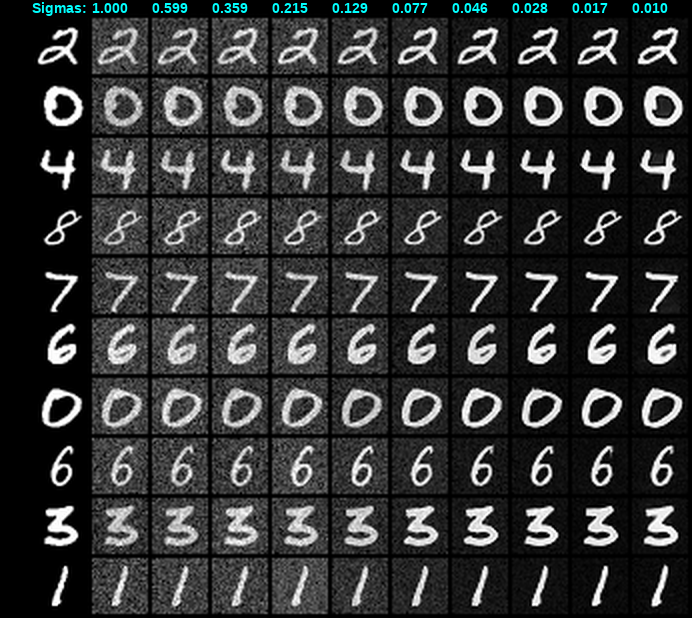

In [656]:
labels = ["Sigmas:"] + ["{:.3f}".format(x) for x in SIGMAS]
im = save_as_timeline(samples, resize_ratio=2, fontsize=7, col_labels=labels)
im

### T=1000

In [514]:
%%time
samples = generate(model, mnist_seeds, T=1000)

CPU times: user 3min 36s, sys: 56.2 s, total: 4min 32s
Wall time: 2min 51s


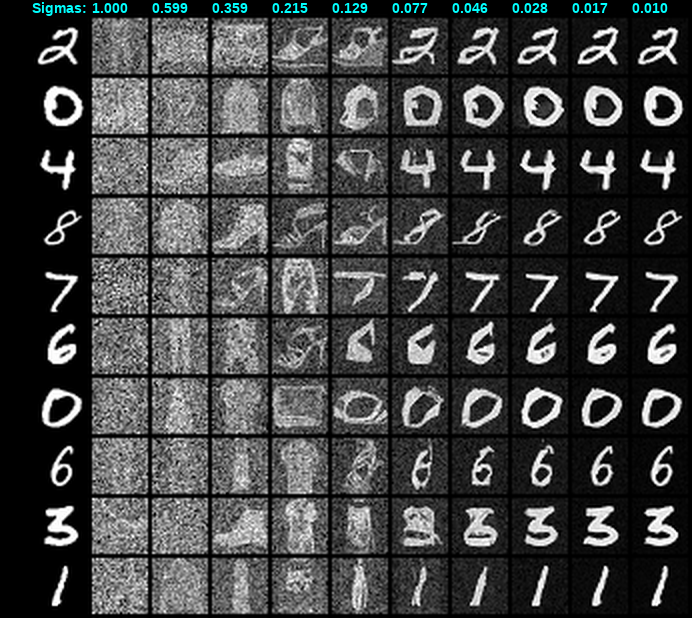

In [516]:
labels = ["Sigmas:"] + ["{:.3f}".format(x) for x in SIGMAS]
save_directory = './samples/sigma_separated/{}_T{}/'.format(complete_model_name, 100)
fname = save_directory + 'mnist.png'

im = save_as_timeline(samples, resize_ratio=2, fontsize=7, col_labels=labels)
im

### T=10000

In [517]:
%%time
samples_10k = generate(model, mnist_seeds, T=10000)

CPU times: user 36min 11s, sys: 9min 23s, total: 45min 34s
Wall time: 28min 42s


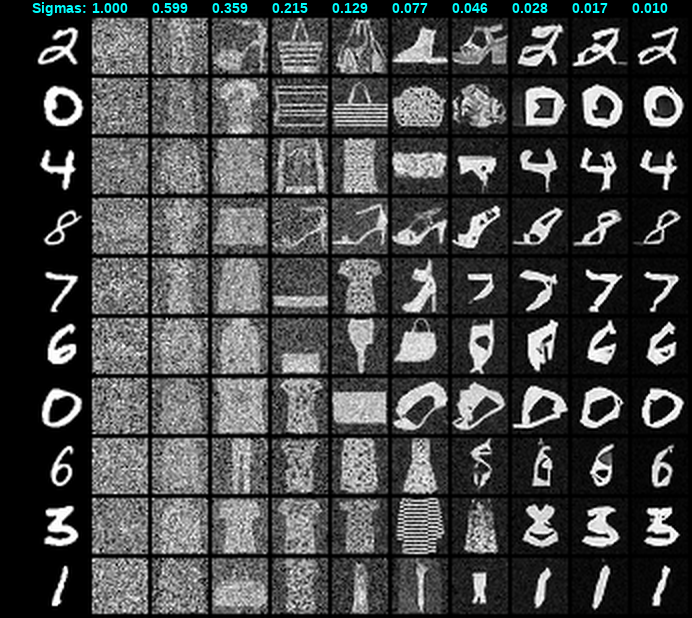

In [518]:
# labels = ["Sigmas:"] + ["{:.3f}".format(x) for x in SIGMAS]
# save_directory = './samples/sigma_separated/{}_T{}/'.format(complete_model_name, 100)
# fname = save_directory + 'mnist.png'

im = save_as_timeline(samples_10k, resize_ratio=2, fontsize=7, col_labels=labels)
im

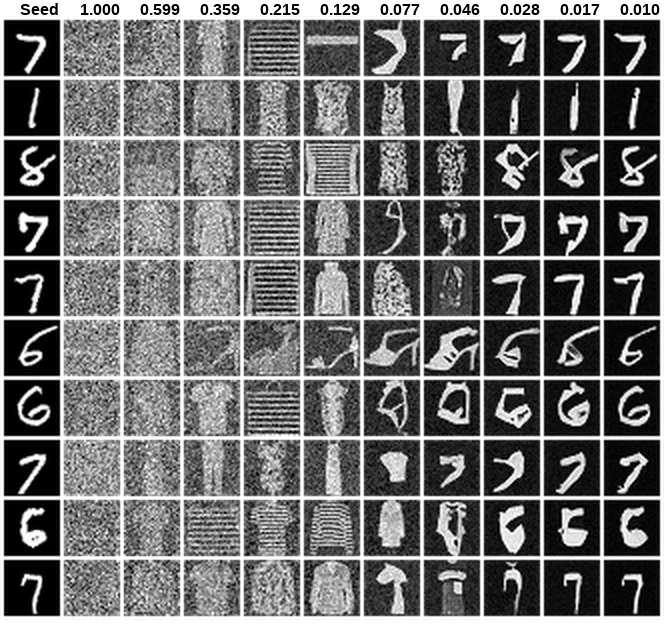

In [212]:
im = save_as_timeline(samples, resize_ratio=2, labels=labels)
im

# Getting Nearest Neighbours

In [290]:
'''
Returns a Tensor: n_samples x k x nn_image
'''

def find_kNN(samples, train_batch, k=3, verbose=False):
    
    x=np.tile(samples, reps=(train_batch.shape[0],1,1,1,1))
    x = np.swapaxes(x,0,1)
    
    diffs = (train_batch-x).reshape(samples.shape[0], train_batch.shape[0],-1)
    dists = np.linalg.norm(diffs, axis=2)
    nn_idxs = np.argpartition(dists, kth=1+np.arange(k), axis=1)[:,:k]
    
    knns = np.array([train_batch[x] for x in nn_idxs])
    min_dists = np.stack([dists[i][x] for i,x in enumerate(nn_idxs)])
#     min_dists = dists[np.arange(samples.shape[0]), min_idxs]
    
    return knns, min_dists

In [556]:
'''
L2 Distance from seed
'''
def displacement(samples, seed):
    diffs = (samples - seed).reshape(*samples.shape[0:2], -1)
    dists = np.linalg.norm(diffs, axis=2)
    
    return dists

In [24]:
with tf.device('CPU'):
    # load dataset from tfds (or use downloaded version if exists)
    fashion_train = get_train_test_data("fashion_mnist")[0]
    fashion_train = fashion_train.batch(60000)
    fashion_train = fashion_train.take(1)
train_batch = next(iter(fashion_train)).numpy()

In [25]:
train_batch.shape

(60000, 28, 28, 1)

### T1000

In [533]:
%%time
timeline_1k = generate_one_sample(model, mnist_seeds[0:1], T=1000, interval=100)
timeline_1k = timeline_1k.numpy()

CPU times: user 3min 30s, sys: 53.2 s, total: 4min 23s
Wall time: 2min 48s


In [121]:
# import pickle

# with open("./timeline_10k.p", "wb") as f:
#     pickle.dump(timeline, f)

In [604]:
%%time
disps = displacement(timeline_1k[1:,...], seed=timeline_1k[0:1,...])
knns, knn_dists = find_kNN(timeline_1k[-1,...], train_batch, k=1)
timeline_knn = np.append(timeline_1k ,np.swapaxes(knns,0,1), axis=0)

CPU times: user 2.11 s, sys: 4.63 s, total: 6.74 s
Wall time: 6.72 s


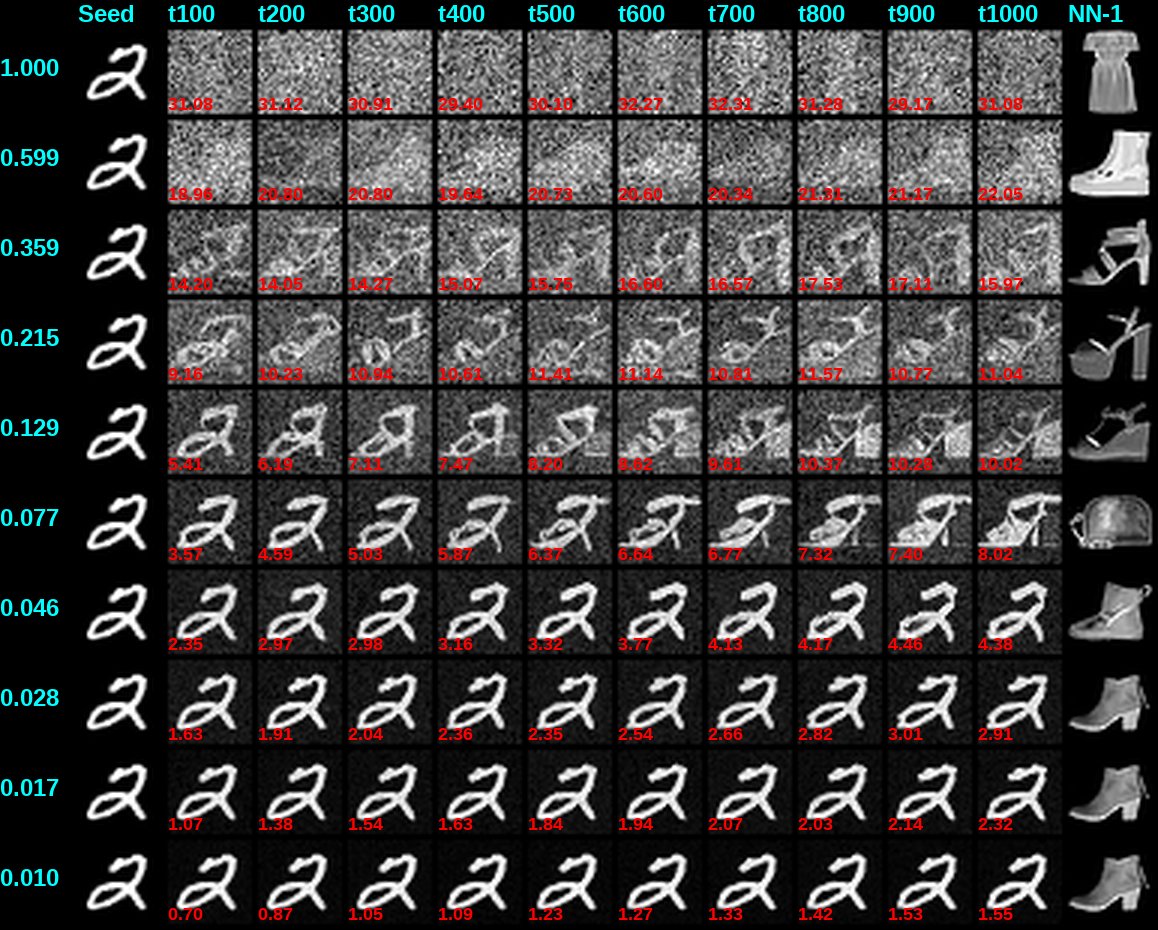

In [605]:
col_labels= ["Seed"] + [f't{(x+1)*100}' for x in range(len(timeline)-1) ] + [f"NN-{x+1}" for x in range(knns.shape[1])]
row_labels = ["{:.3f}".format(s) for s in SIGMAS]
captions = np.zeros(timeline_knn.shape[0:2]) * np.nan
captions[1:-1] = disps
# captions[-1:] = knn_dists.T

im = save_as_timeline(timeline_knn, resize_ratio=3, col_labels=col_labels, row_labels=row_labels, captions=captions)
im

In [585]:
df = pd.DataFrame(disps.T, columns=col_labels[1:-1], index=row_labels)

df.T.plot(figsize=(20,8))
# plt.title('T=1000')
plt.show()

###  T = 10000

In [519]:
%%time
timeline_10k = generate_one_sample(model, mnist_seeds[0:1], T=10000, interval=1000)
timeline_10k = timeline_10k.numpy()

CPU times: user 30min 53s, sys: 8min 16s, total: 39min 9s
Wall time: 24min 31s


In [520]:
import pickle

with open("./timeline_10k.p", "wb") as f:
    pickle.dump(timeline_10k, f)

In [594]:
knns, knn_dists = find_kNN(timeline_10k[-1,...], train_batch, k=1)
timeline_10k_knn = np.append(timeline_10k, np.swapaxes(knns,0,1), axis=0)

disps = displacement(timeline_10k_knn[1:,...], seed=timeline_10k[0:1,...])
captions = np.zeros(timeline_10k_knn.shape[0:2]) * np.nan

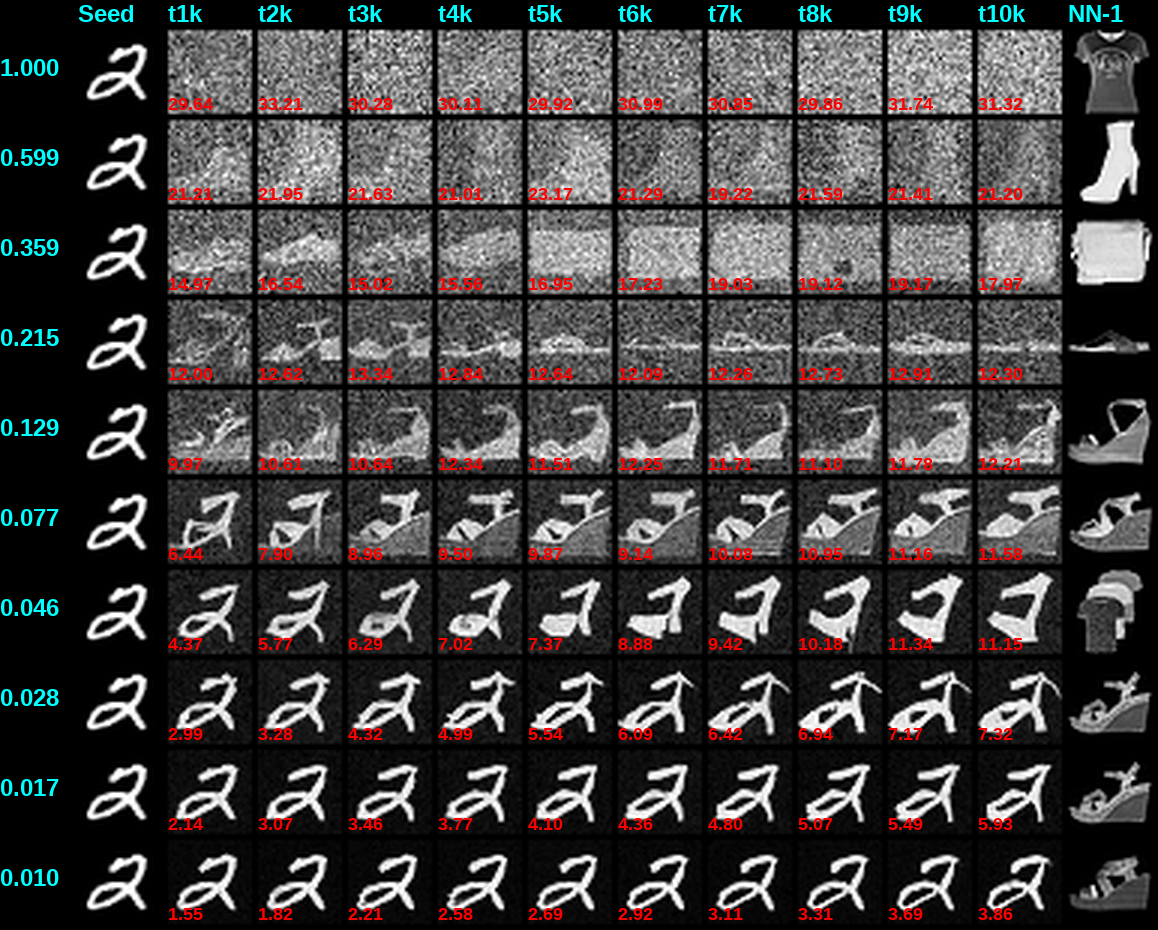

In [600]:
captions[1:] = disps
captions[-1:] = None
col_labels= ["Seed"] + [f't{(x+1)}k' for x in range(len(timeline)-1) ] + [f"NN-{x+1}" for x in range(knns.shape[1])]
row_labels = ["{:.3f}".format(s) for s in SIGMAS]

im = save_as_timeline(timeline_10k_knn, resize_ratio=3, col_labels=col_labels, row_labels=row_labels, captions=captions)
im

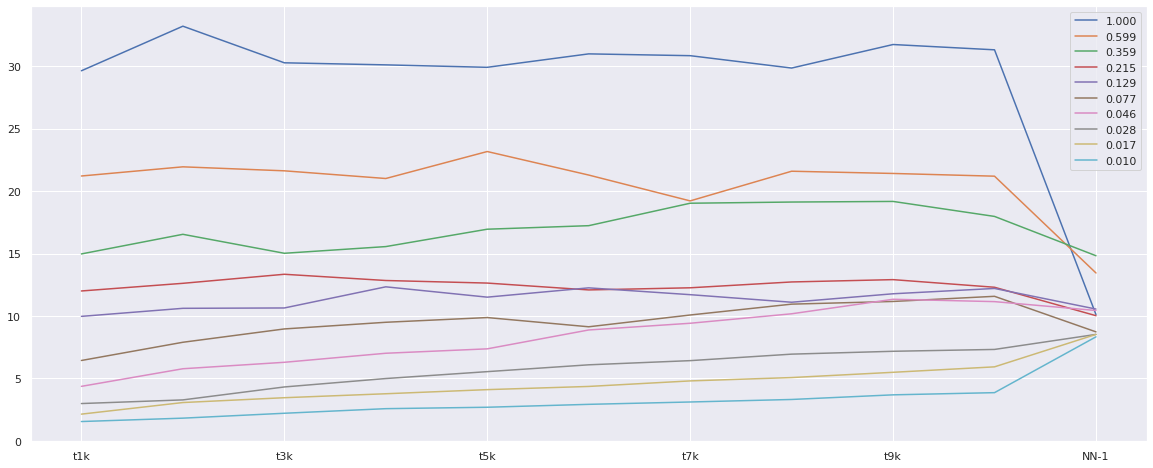

In [599]:
df = pd.DataFrame(disps.T, columns=col_labels[1:], index=row_labels)
df.T.plot(figsize=(20,8))
# plt.title('T=1000')
plt.show()

### Choosing Sigma = 4

In [284]:
%%time
idx=4
timeline_s4 = iterate_one_sigma(model, mnist_seeds, sigma_idx=idx, T=1000, interval=100, verbose=False)
timeline_s4 = timeline_s4.numpy()

CPU times: user 21.1 s, sys: 5.64 s, total: 26.7 s
Wall time: 17 s


In [291]:
samples_s4 = timeline_s4[-1,...]
knns, dists = find_kNN(samples_s4, train_batch)
timeline_s4_knn = np.append(timeline_s4, np.swapaxes(knns,0,1), axis=0)

In [348]:
from concurrent.futures import ThreadPoolExecutor

In [358]:
%%time
with ThreadPoolExecutor(max_workers=6) as executor:
    future = list(executor.map(lambda x: find_kNN(x, train_batch, k=1), timeline_s4))
print(len(future))

11
CPU times: user 25 s, sys: 1min 8s, total: 1min 33s
Wall time: 39 s


In [531]:
%%time
knns = np.array([x[0] for x in future])
dists = np.array([x[1] for x in future]).squeeze()
timeline_s4_knn = np.append(timeline_s4, np.swapaxes(knns[-1],0,1), axis=0)

CPU times: user 740 µs, sys: 170 µs, total: 910 µs
Wall time: 566 µs


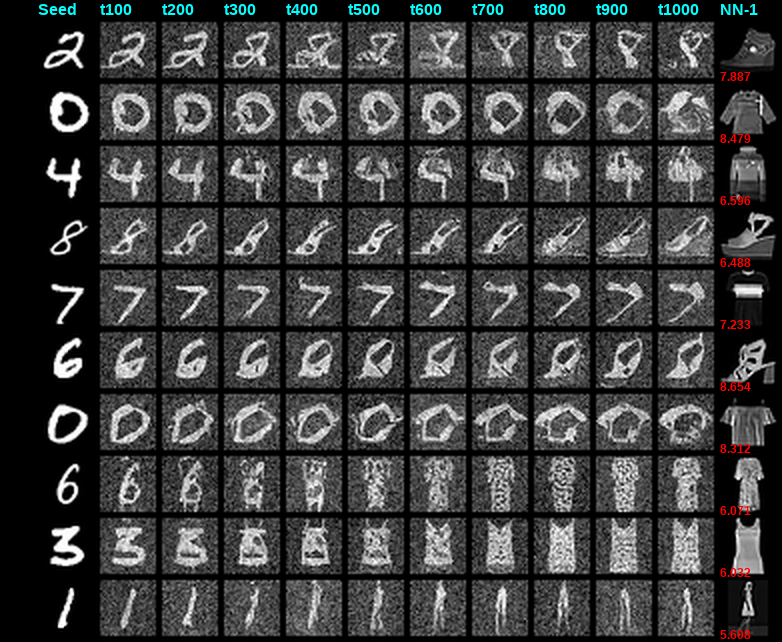

In [532]:
col_labels= ["Seed"] + [f't{(x+1)*100}' for x in range(len(timeline)-1) ] + [f"NN-{x+1}" for x in range(knns.shape[2])]
captions = dists.copy()
captions = np.append(captions, captions[-1:], axis=0)
captions[0:-1] = None

im = save_as_timeline(timeline_s4_knn, resize_ratio=2, spacing=3, col_labels=col_labels, captions=captions)
im

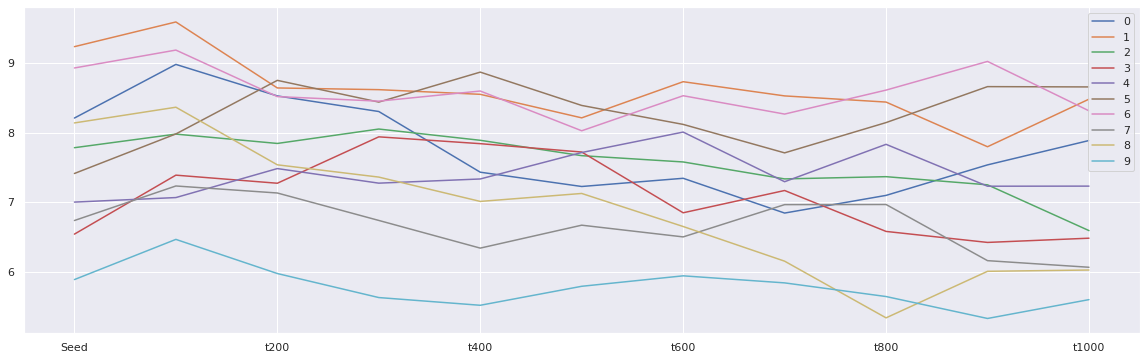

In [475]:
df = pd.DataFrame(dists.T, columns=col_labels[:-1])

df.T.plot(figsize=(20,6))

In [ ]:
with tf.device('CPU'):
    mnist_test = get_train_test_data("mnist")[1]
    mnist_test = mnist_test.batch(1000)

In [ ]:
data_generators = tfds.load(name=dataset_name, batch_size=-1, data_dir="data", shuffle_files=False)

### Fashion Seeds

In [602]:
with tf.device('CPU'):
    # load dataset from tfds (or use downloaded version if exists)
    fashion_test = get_train_test_data("fashion_mnist")[1]
    fashion_test = fashion_test.batch(10)

In [606]:
fashion_seeds = next(iter(fashion_test))

In [619]:
%%time
samples = generate(model, fashion_seeds, T=1000)
disps = displacement(samples[1:,...], seed=samples[0:1,...])

CPU times: user 3min 49s, sys: 55.9 s, total: 4min 44s
Wall time: 3min 2s


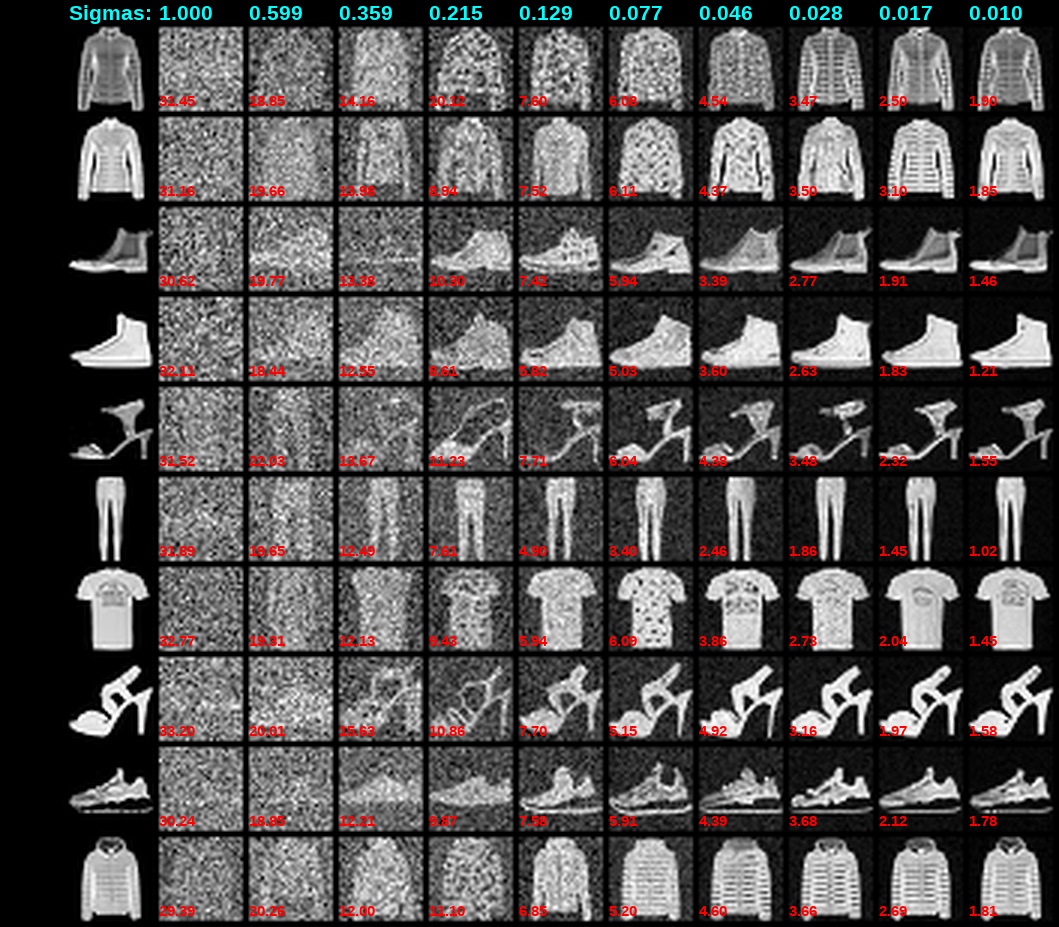

In [620]:
labels = ["Sigmas:"] + ["{:.3f}".format(x) for x in SIGMAS]
captions = np.zeros(samples.shape[0:2]) * np.nan
captions[1:] = disps
# captions[-1:] = knn_dists.T

im = save_as_timeline(samples, resize_ratio=3, fontsize=7, col_labels=labels, captions=captions)
im

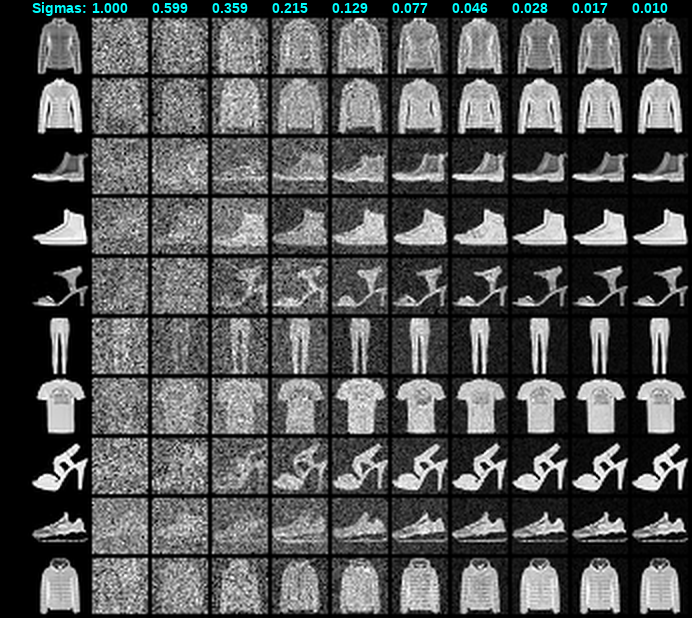

In [611]:
labels = ["Sigmas:"] + ["{:.3f}".format(x) for x in SIGMAS]
im = save_as_timeline(samples, resize_ratio=2, fontsize=7, col_labels=labels)
im

In [612]:
%%time
timeline_f = generate_one_sample(model, fashion_seeds[0:1], T=10, interval=1)
timeline_f = timeline_f.numpy()

CPU times: user 2.44 s, sys: 609 ms, total: 3.05 s
Wall time: 1.96 s


In [613]:
%%time
disps = displacement(timeline_f[1:,...], seed=timeline_f[0:1,...])
knns, knn_dists = find_kNN(timeline_f[-1,...], train_batch, k=1)
timeline_knn = np.append(timeline_f, np.swapaxes(knns,0,1), axis=0)

CPU times: user 1.88 s, sys: 4.33 s, total: 6.21 s
Wall time: 6.18 s


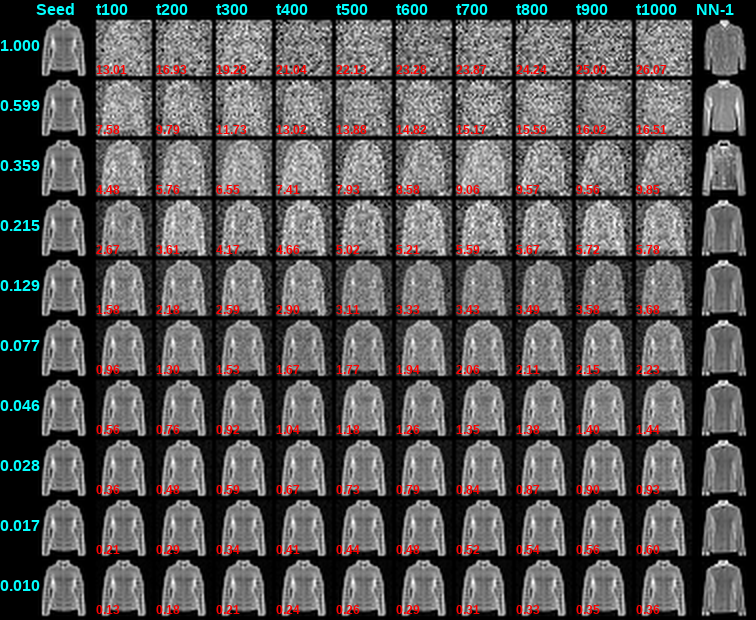

In [615]:
col_labels= ["Seed"] + [f't{(x+1)*100}' for x in range(len(timeline)-1) ] + [f"NN-{x+1}" for x in range(knns.shape[1])]
row_labels = ["{:.3f}".format(s) for s in SIGMAS]
captions = np.zeros(timeline_knn.shape[0:2]) * np.nan
captions[1:-1] = disps
# captions[-1:] = knn_dists.T

im = save_as_timeline(timeline_knn, resize_ratio=2, col_labels=col_labels, row_labels=row_labels, captions=captions)
im

In [585]:
df = pd.DataFrame(disps.T, columns=col_labels[1:-1], index=row_labels)

df.T.plot(figsize=(20,8))
# plt.title('T=1000')
plt.show()